In [1]:
# Importar librerias

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, PercentFormatter
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.utils import Bunch
from IPython.display import clear_output
from scipy.optimize import minimize
from sklearn.base import clone, BaseEstimator, RegressorMixin
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
#from pytorch_tabnet.tab_model import TabNetRegressor
#from pytorch_tabnet.callbacks import Callback


from sklearn.metrics import cohen_kappa_score, make_scorer, mean_squared_error
from lightgbm import plot_importance  
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

# Importar data tabular

In [2]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

# Data analysis

In [3]:
train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [5]:
print("train: ", train.shape)
print("test: ", test.shape)

train:  (3960, 82)
test:  (20, 59)


## Distribucion de variables

La data esta muy desbalanceada, mas de la mitad de las observaciones son de 0

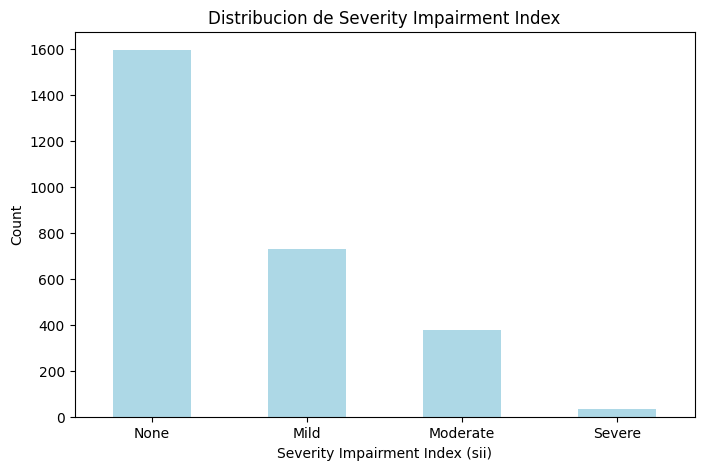

In [6]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

train['sii'].value_counts().sort_index().plot(kind='bar', color='lightblue', figsize=(8, 5))

plt.xticks(ticks=range(len(target_labels)), labels=target_labels, rotation=0) 
plt.ylabel('Count')
plt.xlabel('Severity Impairment Index (sii)')
plt.title('Distribucion de Severity Impairment Index')
plt.show()

### Distribucion de edades por genero

Chicos y chicas tienen una distribucion similar

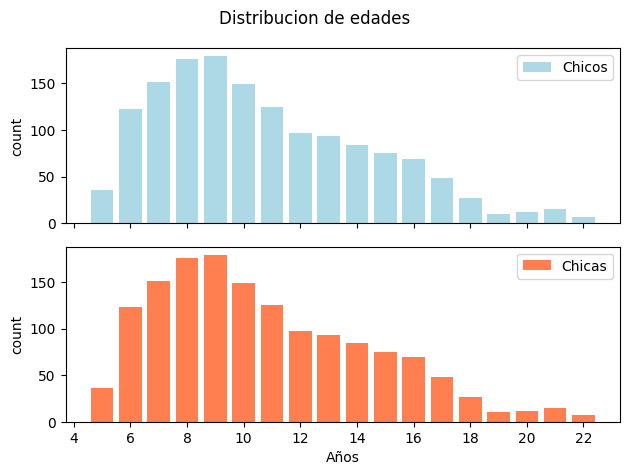

In [7]:
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.loc[train['Basic_Demos-Sex'] == 1, 'Basic_Demos-Age'].value_counts()
    ax.bar(vc.index,
           vc,
           color=['lightblue', 'coral'][sex],
           label=['Chicos', 'Chicas'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Distribucion de edades')
axs.ravel()[1].set_xlabel('Años')
plt.tight_layout()
plt.show()

### Distribucion de target por genero

El desbalanceo en la data es similar para ambos generos

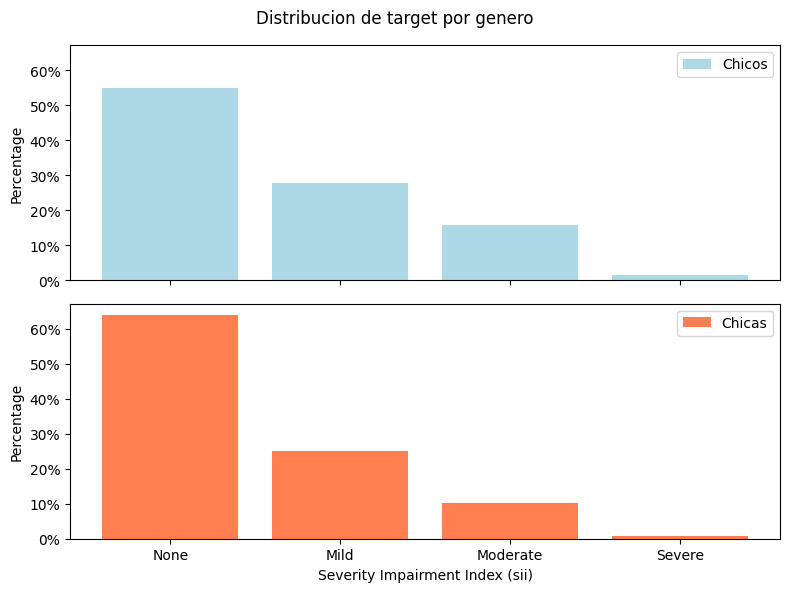

In [8]:
_, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6))
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.loc[train['Basic_Demos-Sex'] == sex, 'sii'].value_counts(normalize=True)
    ax.bar(vc.index,
           vc.values,
           color=['lightblue', 'coral'][sex],
           label=['Chicos', 'Chicas'][sex])
    
    ax.set_xticks(range(len(target_labels)))
    ax.set_xticklabels(target_labels)
    
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('Percentage')
    ax.legend()

plt.suptitle('Distribucion de target por genero')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.tight_layout()
plt.show()

## Analisis de la actigrafia (Patrones de sueño basados en la cantidad de movimientos que hace cuando está dormido y despierto)

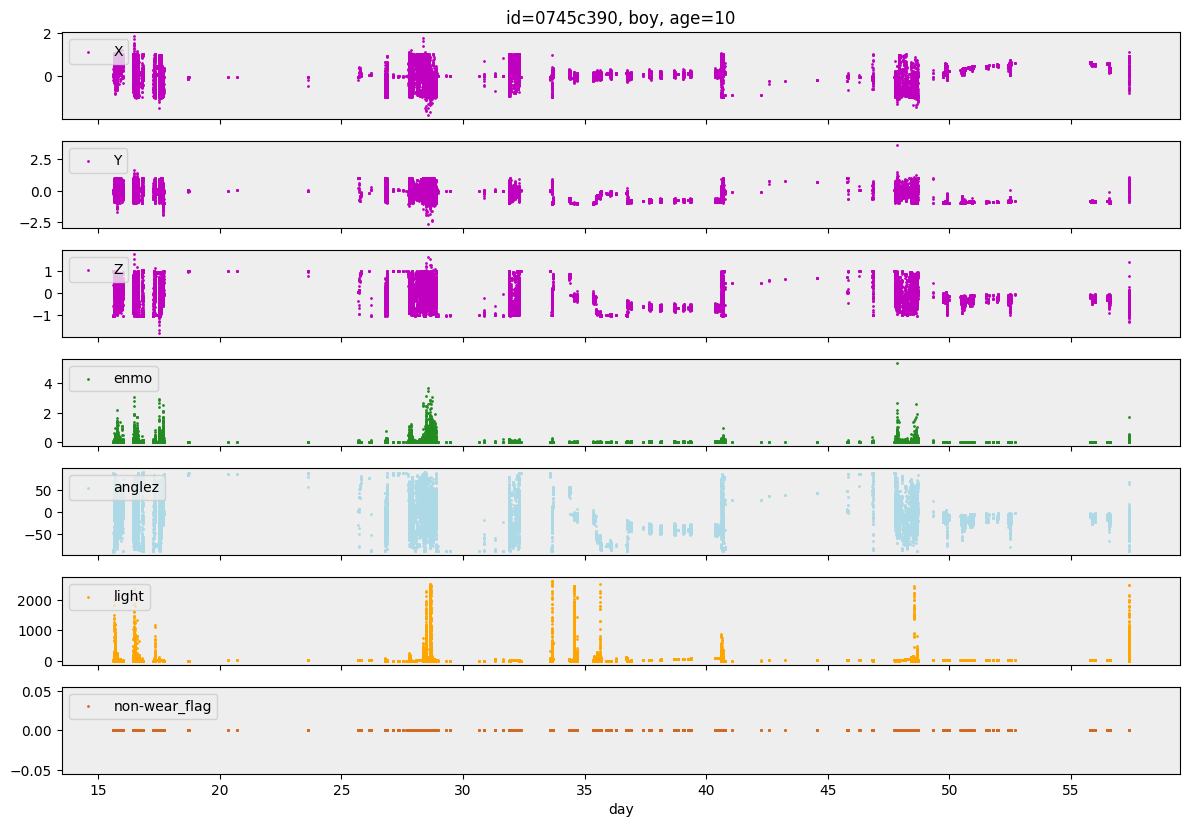

In [9]:

def analyze_actigraphy(id, only_one_week=False, small=False):
    # Load actigraphy data
    actigraphy = pd.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    
    # Compute day
    actigraphy['day'] = actigraphy['relative_date_PCIAT'] + actigraphy['time_of_day'] / 86400e9
    
    # Extract age and sex from `train`
    sample = train[train['id'] == id].iloc[0]
    age = sample['Basic_Demos-Age']
    sex = ['boy', 'girl'][sample['Basic_Demos-Sex']]
    
    # Compute additional columns
    actigraphy['diff_seconds'] = actigraphy['day'].diff() * 86400
    actigraphy['norm'] = np.sqrt(actigraphy['X']**2 + actigraphy['Y']**2 + actigraphy['Z']**2)
    
    # Apply filtering for one week if requested
    if only_one_week:
        start = np.ceil(actigraphy['day'].min())
        mask = (start <= actigraphy['day']) & (actigraphy['day'] <= start + 7 * 3)
        mask &= ~actigraphy['non-wear_flag'].astype(bool)
    else:
        mask = np.full(len(actigraphy), True)
        
    # Define timelines based on `small` flag
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate'),
        ]
    
    # Create subplots
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(actigraphy['day'][mask], 
                   actigraphy[feature][mask], 
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

analyze_actigraphy('0745c390', only_one_week=False)

## Features en test y train

- El set de entrenamiento tiene varias features que no estan presentes en el set de testeo
- Vamos a usar las features que esten en ambos sets

In [10]:
train_col = train.columns.tolist()
test_col = test.columns.tolist()

features = test_col + ['sii']

missing_features_train = [f for f in train_col if f not in test_col]
missing_features_test = [f for f in test_col if f not in train_col]

print('Features en el set de entrenamiento que no estan en el de testeo: ',missing_features_train)

Features en el set de entrenamiento que no estan en el de testeo:  ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


In [11]:
print('Features en el set de testeo que no estan en el de entrenamiento: ',missing_features_test)

Features en el set de testeo que no estan en el de entrenamiento:  []


## Missing values

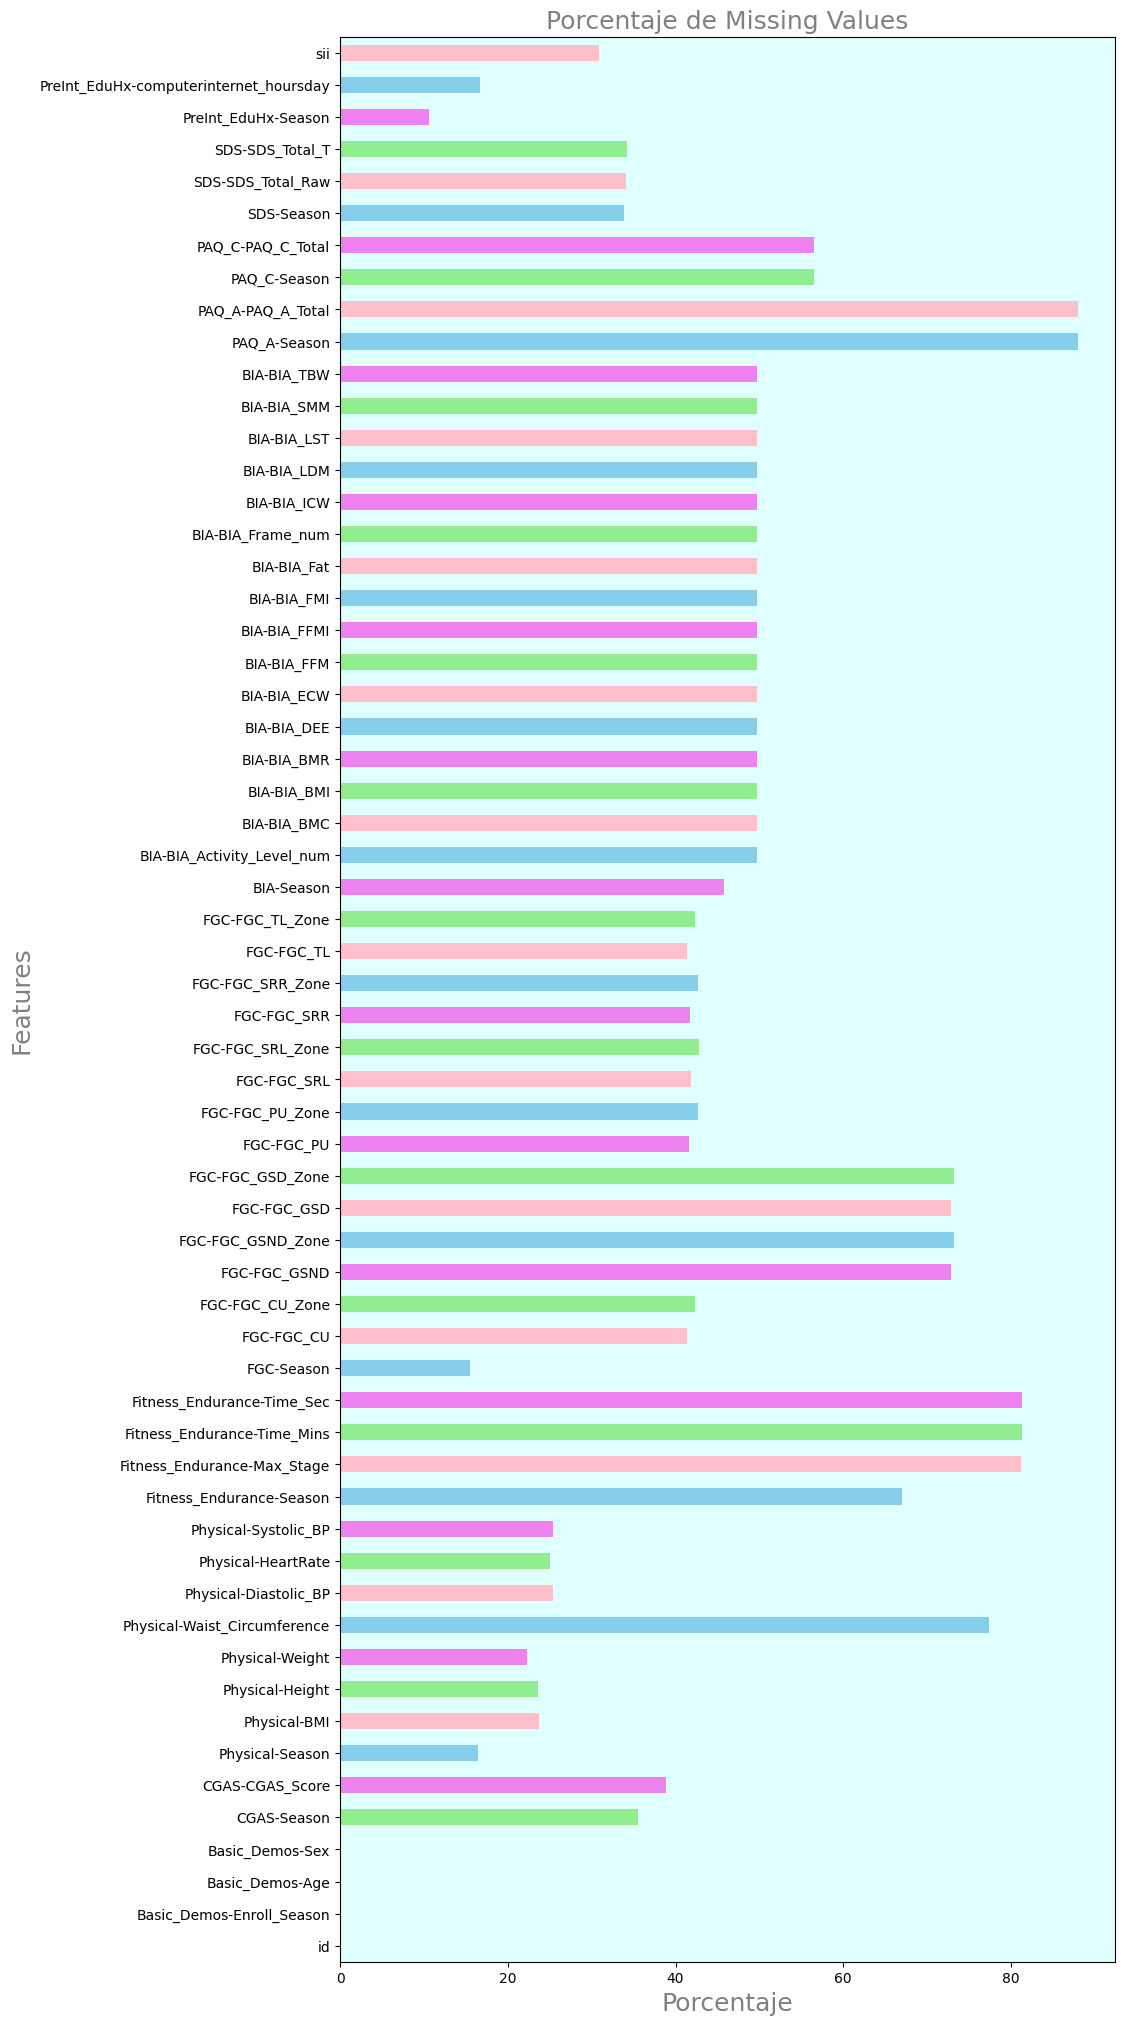

In [12]:
train = train[features]
missing_values = train.isnull().mean() * 100
missing_values.plot(kind='barh', figsize=(10, 25), color=['lightgreen','violet','skyblue','pink'])

plt.title('Porcentaje de Missing Values', fontsize=18, color='gray')
plt.xlabel('Porcentaje', fontsize=18, color='gray')
plt.ylabel('Features', fontsize=18, color='gray')
plt.gca().set_facecolor('lightcyan')
plt.xticks(rotation=0)
plt.show()

## Correlacion

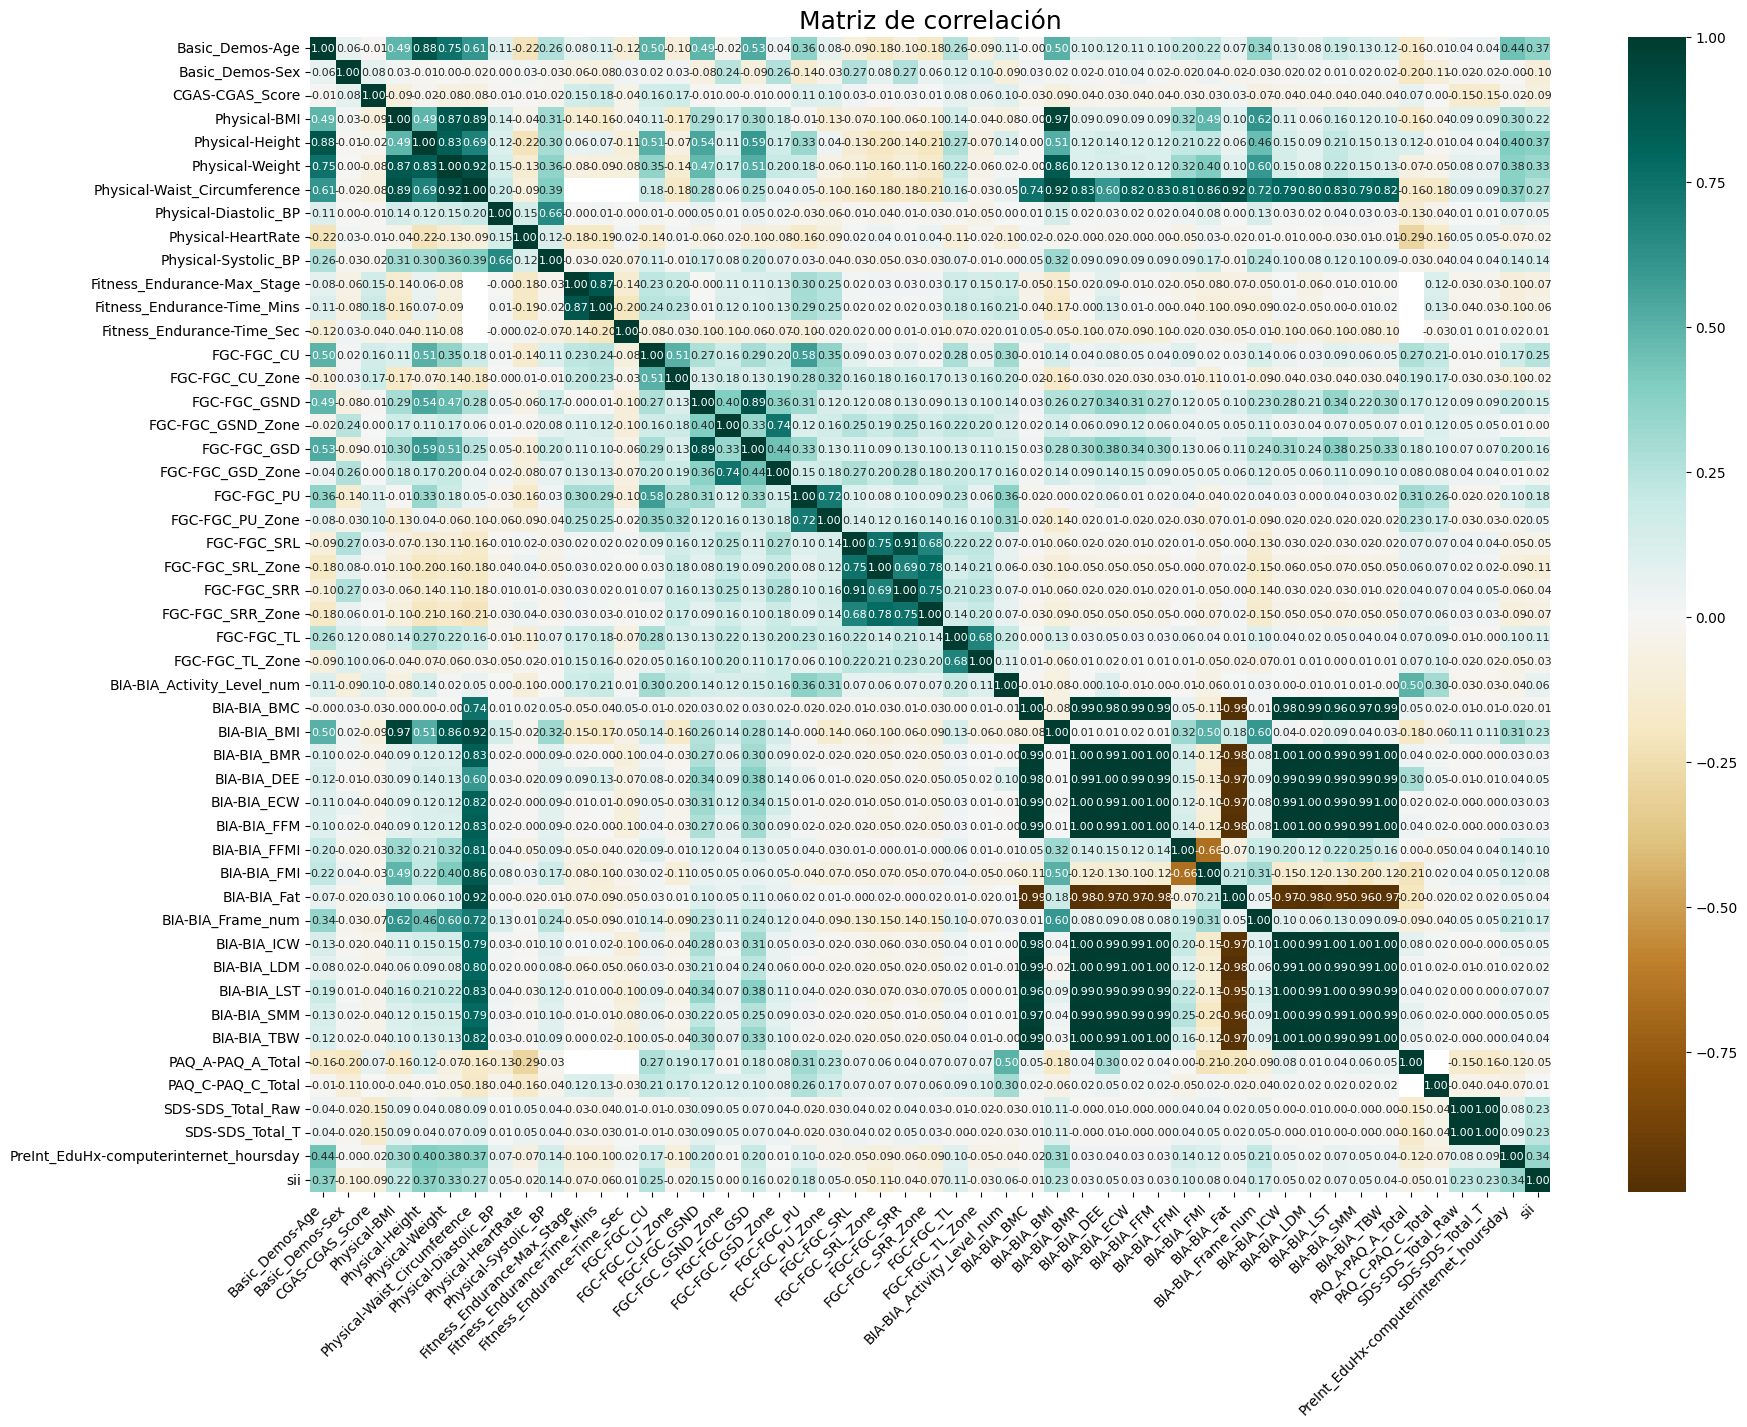

In [13]:
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = train[numeric_cols].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='BrBG', fmt=".2f", annot_kws={"size": 8})

plt.title('Matriz de correlación', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10) 

plt.show()

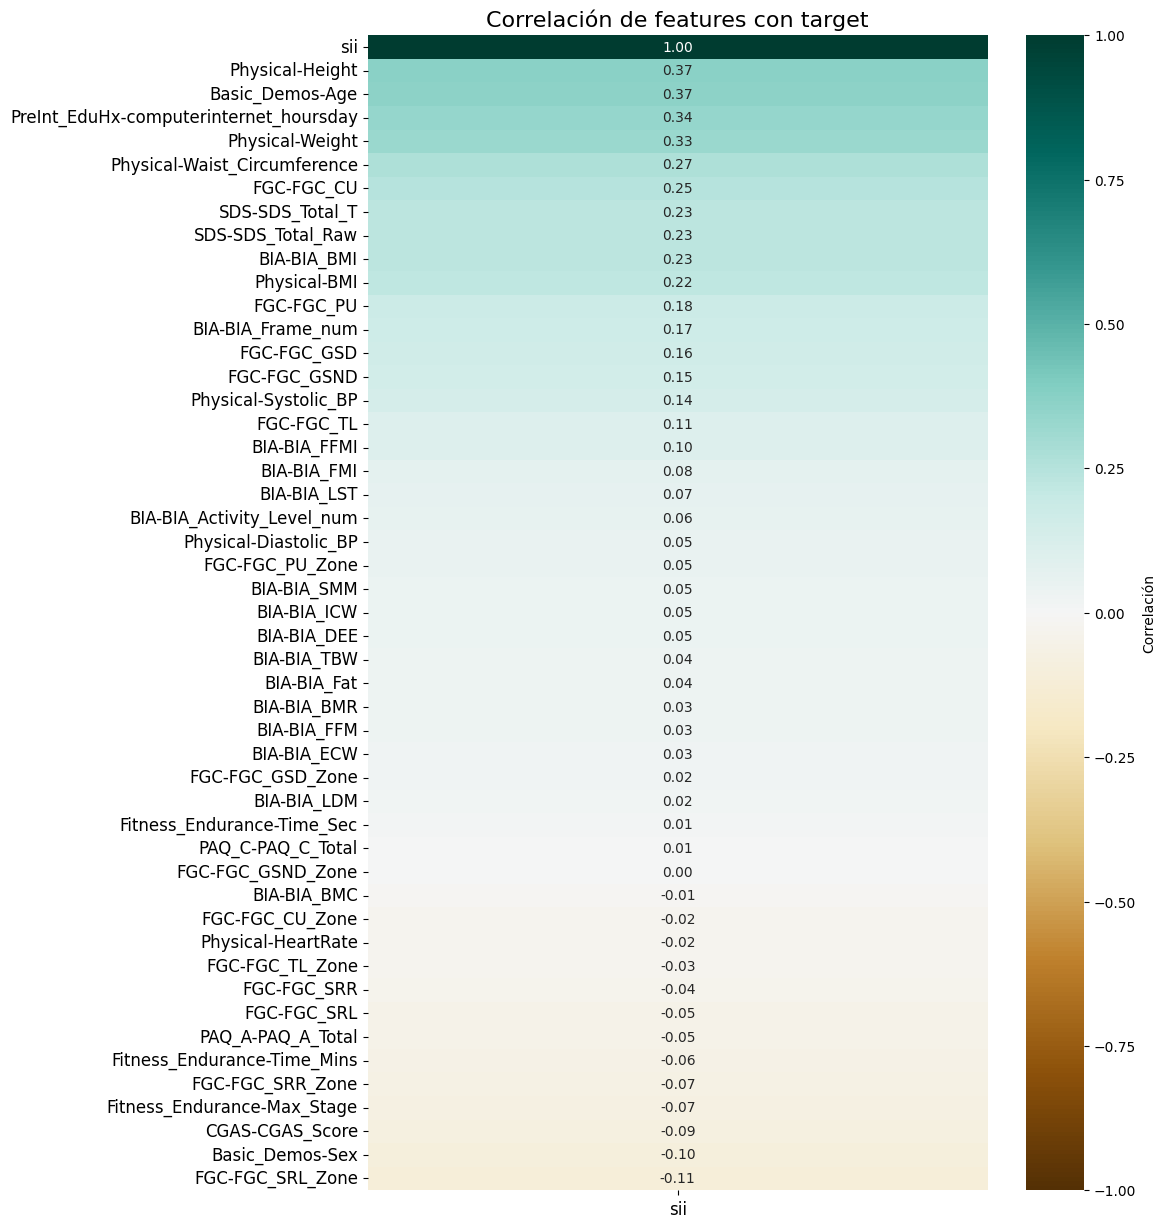

In [14]:
plt.figure(figsize=(10, 15)) 

sns.heatmap(
    train[numeric_cols].corr()[['sii']].sort_values(by='sii', ascending=False),
    annot=True,
    fmt=".2f",
    cmap='BrBG',
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Correlación'}
)

plt.title('Correlación de features con target', fontsize=16)
plt.yticks(fontsize=12, rotation=0)
plt.xticks(fontsize=12)

plt.show()

# Preprocesamiento

- Imputar missing values numericos usando KNNImputer
- Encodear features categoricas creando mappings para cada feature (Todas las features categoricas estan relacionadas con las estaciones del año)
- Usar autoencoder para series de tiempo
- Unir estadisticas de las series de tiempo (Media, desvio estandar, etc) con la data tabular de entrenamiento por id
- Crear nuevas features

## Autoencoder con Pytorch

## Funcion para cargar data de serie de tiempo

In [15]:
def process_file(filename, dirname):
    data = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    data.drop('step', axis=1, inplace=True)
    return data.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname):
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    data = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    data['id'] = indexes
    
    return data

## Pipeline de procesamiendo

In [16]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df_numeric = df[numeric_cols]
    
    df_numeric = df_numeric.loc[:, df_numeric.std() > 0]
    
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_numeric), 
        columns=df_numeric.columns,
        index=df_numeric.index
    )
    
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_imputed), 
        columns=df_imputed.columns,
        index=df_imputed.index
    )
    
    data_tensor = torch.FloatTensor(df_scaled.values)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    best_loss = float('inf')
    patience = 5
    trigger_times = 0

    
    if len(data_tensor) < batch_size:
        print("Ajustar batch size")
        batch_size = len(data_tensor)
    
    for epoch in range(epochs):
        autoencoder.train()
        epoch_loss = 0.0
    
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i: i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
    
            epoch_loss += loss.item()
    
        if len(data_tensor) > 0:
            epoch_loss /= (len(data_tensor) // batch_size)
    
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            trigger_times = 0
        else:
            trigger_times += 1
    
        if trigger_times >= patience:
            print(f'Early stopping en epoch {epoch + 1}')
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}')
    
    with torch.no_grad():
        autoencoder.eval()
        encoded_data = autoencoder.encoder(data_tensor).numpy()
    
    df_encoded = pd.DataFrame(
        encoded_data, 
        columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])],
        index=df_numeric.index
    )
    
    return df_encoded

In [17]:
class Preprocessing:
    def __init__(self, train_path, test_path, sample_path, series_train_path, series_test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.sample_path = sample_path
        self.series_train_path = series_train_path
        self.series_test_path = series_test_path
        self.train = None
        self.test = None
        self.sample = None
        self.train_ts = None
        self.test_ts = None
        self.train_ts_encoded = None
        self.test_ts_encoded = None
        self.season_encoder = None

    def load_data(self):
        """Cargar data"""
        try:
            self.train = pd.read_csv(self.train_path)
            self.test = pd.read_csv(self.test_path)
            self.sample = pd.read_csv(self.sample_path)
            
            test_columns = self.test.columns.tolist()
            features = test_columns + ['sii'] if 'sii' not in test_columns else test_columns
            
            self.train = self.train[features]
            
            self.train_ts = load_time_series(self.series_train_path)
            self.test_ts = load_time_series(self.series_test_path)
            
        except FileNotFoundError as e:
            print(f"Error loading file: {e}")
            raise
        except Exception as e:
            print(f"Error en data loading: {e}")
            raise

    def encode_time_series(self, encoding_dim=50, epochs=100, batch_size=32):
        """Encodear serie de tiempo con autoencoder"""
        try:
            df_train = self.train_ts.drop('id', axis=1, errors='ignore')
            df_test = self.test_ts.drop('id', axis=1, errors='ignore')

            print(f"Train dataset size: {len(self.train_ts)}")
            print(f"Test dataset size: {len(self.test_ts)}")

            self.train_ts_encoded = perform_autoencoder(
                df_train, 
                encoding_dim=encoding_dim, 
                epochs=epochs, 
                batch_size=batch_size
            )
            self.test_ts_encoded = perform_autoencoder(
                df_test, 
                encoding_dim=encoding_dim, 
                epochs=epochs, 
                batch_size=batch_size
            )

            self.train_ts_encoded['id'] = self.train_ts.get('id', range(len(self.train_ts_encoded)))
            self.test_ts_encoded['id'] = self.test_ts.get('id', range(len(self.test_ts_encoded)))

        except Exception as e:
            print(f"Error en time series encoding: {e}")
            raise

    def merge_data(self):
        """Unir data de serie de tiempo con data tabular"""
        self.train = pd.merge(self.train, self.train_ts_encoded, how="left", on='id', suffixes=('', '_encoded'))
        self.test = pd.merge(self.test, self.test_ts_encoded, how="left", on='id', suffixes=('', '_encoded'))

        
        numeric_cols = self.train.drop('sii', axis = 1).select_dtypes(include=["number"]).columns
        for col in numeric_cols:
            self.train[col] = self.train[col].replace([np.inf, -np.inf], np.nan)
            self.test[col] = self.test[col].replace([np.inf, -np.inf], np.nan)
            
            if col != 'sii':
                train_mean = self.train[col].mean()
                train_std = self.train[col].std()
                
                self.train[col] = np.clip(
                    self.train[col], 
                    train_mean - 3 * train_std, 
                    train_mean + 3 * train_std
                )
                self.test[col] = np.clip(
                    self.test[col], 
                    train_mean - 3 * train_std, 
                    train_mean + 3 * train_std
                )

    def impute_missing_values(self):
        """Imputar missing values"""
        self.train = self.train.dropna(subset=['sii'])
        
        numeric_cols = self.train.drop('sii', axis = 1).select_dtypes(include=['number']).columns.tolist()
        
        numeric_cols = [
            col for col in numeric_cols 
            if not self.train[col].isna().all() and 
               self.train[col].std() > 0 and 
               self.train[col].isna().mean() < 0.5 
        ]
        
        imputer = KNNImputer(n_neighbors=5)
        
        self.train[numeric_cols] = imputer.fit_transform(self.train[numeric_cols])
        self.test[numeric_cols] = imputer.transform(self.test[numeric_cols])

    def feature_engineering(self, df, fitted_encoder=None):
        """Feature engeneering - Encodear variables categoricas, crear nuevas features"""
        season_cols = [col for col in df.columns if 'Season' in col]

        for col in season_cols:
            df[col] = df[col].fillna('Desconocido').astype('category')

        if fitted_encoder is None:
            encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
            season_encoded = encoder.fit_transform(df[season_cols])
            
            encoded_cols = encoder.get_feature_names_out(season_cols)
            
            for i, col in enumerate(encoded_cols):
                df[col] = season_encoded[:, i]
        else:
            encoder = fitted_encoder
            season_encoded = encoder.transform(df[season_cols])
            
            encoded_cols = encoder.get_feature_names_out(season_cols)
            
            for i, col in enumerate(encoded_cols):
                df[col] = season_encoded[:, i]

        df = df.drop(columns=season_cols)

        engineering_features = [
            ('BMI_Age', lambda x: x['Physical-BMI'] * x['Basic_Demos-Age']),
            ('Internet_Hours_Age', lambda x: x['PreInt_EduHx-computerinternet_hoursday'] / (x['Basic_Demos-Age'] + 1e-10)),
            ('BMI_Internet_Hours', lambda x: x['Physical-BMI'] * x['PreInt_EduHx-computerinternet_hoursday']),
            ('BFP_BMI', lambda x: x['BIA-BIA_Fat'] / (x['BIA-BIA_BMI'] + 1e-10)),
            ('FFMI_BFP', lambda x: x['BIA-BIA_FFMI'] / (x['BIA-BIA_Fat'] + 1e-10)),
            ('FMI_BFP', lambda x: x['BIA-BIA_FMI'] / (x['BIA-BIA_Fat'] + 1e-10)),
            ('LST_TBW', lambda x: x['BIA-BIA_LST'] / (x['BIA-BIA_TBW'] + 1e-10)),
            ('BFP_BMR', lambda x: x['BIA-BIA_Fat'] * x['BIA-BIA_BMR']),
            ('BFP_DEE', lambda x: x['BIA-BIA_Fat'] * x['BIA-BIA_DEE']),
            ('BMR_Weight', lambda x: x['BIA-BIA_BMR'] / (x['Physical-Weight'] + 1e-10)),
            ('DEE_Weight', lambda x: x['BIA-BIA_DEE'] / (x['Physical-Weight'] + 1e-10)),
            ('SMM_Height', lambda x: x['BIA-BIA_SMM'] / (x['Physical-Height'] + 1e-10)),
            ('Muscle_to_Fat', lambda x: x['BIA-BIA_SMM'] / (x['BIA-BIA_FMI'] + 1e-10)),
            ('Hydration_Status', lambda x: x['BIA-BIA_TBW'] / (x['Physical-Weight'] + 1e-10)),
            ('ICW_TBW', lambda x: x['BIA-BIA_ICW'] / (x['BIA-BIA_TBW'] + 1e-10))
        ]

        for feature_name, feature_func in engineering_features:
            df[feature_name] = df.apply(feature_func, axis=1)

        return df, encoder if fitted_encoder is None else None

    def apply_feature_engineering(self):
        """Aplicar feature engeneering y escalar"""
        scaler = StandardScaler()

        self.train, self.season_encoder = self.feature_engineering(self.train)
        
        self.test, _ = self.feature_engineering(self.test, fitted_encoder=self.season_encoder)

        numeric_cols = self.test.select_dtypes(include=['number']).columns.tolist()
        
        numeric_cols = [col for col in numeric_cols if self.train[col].std() > 0]

        X_train_scaled = scaler.fit_transform(self.train[numeric_cols])
        X_test_scaled = scaler.transform(self.test[numeric_cols])

        self.train[numeric_cols] = X_train_scaled
        self.test[numeric_cols] = X_test_scaled

        cols = self.train.columns[self.train.isnull().any()].tolist()
        for col in cols:
            self.train[col] = self.train[col].fillna(self.train[col].median())

        cols = self.test.columns[self.test.isnull().any()].tolist()
        for col in cols:
            self.test[col] = self.test[col].fillna(self.test[col].median())

    
    def drop_id_column(self):
        """Dropear id"""
        self.train = self.train.set_index('id')
        self.test = self.test.set_index('id')

    def preprocess(self):
        """Ejecutar toda la pipeline"""
        try:
            self.load_data()
            self.encode_time_series()
            self.merge_data()
            self.impute_missing_values()
            self.apply_feature_engineering()
            self.drop_id_column()

            return self.train, self.test, self.sample
        except Exception as e:
            print(f"Error in preprocessing pipeline: {e}")
            raise

## Ejecutar pipeline

In [18]:
preprocessor = Preprocessing(
    train_path='/kaggle/input/child-mind-institute-problematic-internet-use/train.csv',
    test_path='/kaggle/input/child-mind-institute-problematic-internet-use/test.csv',
    sample_path='/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv',
    series_train_path='/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet',
    series_test_path='/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet'
)

train, test, sample = preprocessor.preprocess()

100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


Train dataset size: 996
Test dataset size: 2
Ajustar batch size


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/tmp/ipykernel_23/3425324884.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = season_encoded[:, i]
/tmp/ipykernel_23/3425324884.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = season_encoded[:, i]
/tmp/ipykernel_23/3425324884.py:126:

# Modelos y evaluacion

- Usaremos un ensamble de 3 modelos (XGBoost, LightGBM y un Tab-Transformer) con un Voting Regressor:

*     Gradient Boosting Machines: LightGBM y XGBoost ideales para data tabular. Pueden captar relaciones complejas y no lineales
*     Neural Network: El transformador con PyTorch agrega el componente de una red neuronal, que es capaz de aprender features distintas a las de los modelos de arbol
s.
- Dado que el target es una variable ordinal, usaremos Quadratic Weighted Kappa (QWK) para evaluar las estimaciones de los modelos dado que penaliza mas fuertemente los errores que estan mas lejos del valor observado
- Por ejemplo, si el valor observado es 3, si usaramos accuracy la penalizacion seria la misma para una prediccion de 1 o 2. En cambio, QWK penaliza mas fuertemente la prediccion de 1 que la de 2
- Tambien usaremos el LightGBM para hacer feature selection evaluando los QWK

### Funciones auxiliares

In [19]:
def round_t(pred_raw, t):
    return np.where(pred_raw < t[0], 0,
                    np.where(pred_raw < t[1], 1,
                             np.where(pred_raw < t[2], 2, 3)))

# QWK negativo para optimizacion
def fun(t, y_true, pred_raw):
    pred = round_t(pred_raw, t)
    return -cohen_kappa_score(y_true, pred, weights='quadratic')

# Optimizar thresholds
def optimized_thresholds(fun, y_true, pred_raw):
    res = minimize(fun, x0=[0.5, 1.5, 2.5], args=(y_true, pred_raw), method='Nelder-Mead')
    assert res.success, "Optimization did not converge."
    return np.sort(res.x.round(2))

# Quadratic weighted kappa
def qw_kappa(y_true, pred):
    return cohen_kappa_score(y_true, pred, weights='quadratic')

In [20]:
X = train.drop('sii', axis=1)
y = train['sii']

## LightGBM

In [21]:
lgbm_params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 413,
    'min_data_in_leaf': 14,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.76,
    'bagging_freq': 2,
    'lambda_l1': 4.735,
    'lambda_l2': 4.735e-06,
    'random_state': 23
}

"""lgbm_params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 7,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06
    'device': 'cpu',
    'random_state': 23
}"""

"lgbm_params = {\n    'learning_rate': 0.046,\n    'max_depth': 12,\n    'num_leaves': 478,\n    'min_data_in_leaf': 13,\n    'feature_fraction': 0.893,\n    'bagging_fraction': 0.784,\n    'bagging_freq': 4,\n    'lambda_l1': 7,  # Increased from 6.59\n    'lambda_l2': 0.01,  # Increased from 2.68e-06\n    'device': 'cpu',\n    'random_state': 23\n}"

In [22]:
lgbm = LGBMRegressor(**lgbm_params, verbose=-1)

## Optimizacion de threshold

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

lgbm = LGBMRegressor(**lgbm_params, verbose=-1)
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

t = optimized_thresholds(fun, y_test, y_pred)

# t = [0.55, 1.44, 2.19] -> Tresholds optimos

In [24]:
lgbm = LGBMRegressor(**lgbm_params, verbose=-1)
lgbm.fit(X, y)

LGBMRegressor(bagging_fraction=0.76, bagging_freq=2, feature_fraction=0.8,
              lambda_l1=4.735, lambda_l2=4.735e-06, learning_rate=0.046,
              max_depth=12, min_data_in_leaf=14, num_leaves=413,
              random_state=23, verbose=-1)

## Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='Importancia', ylabel='Feature'>

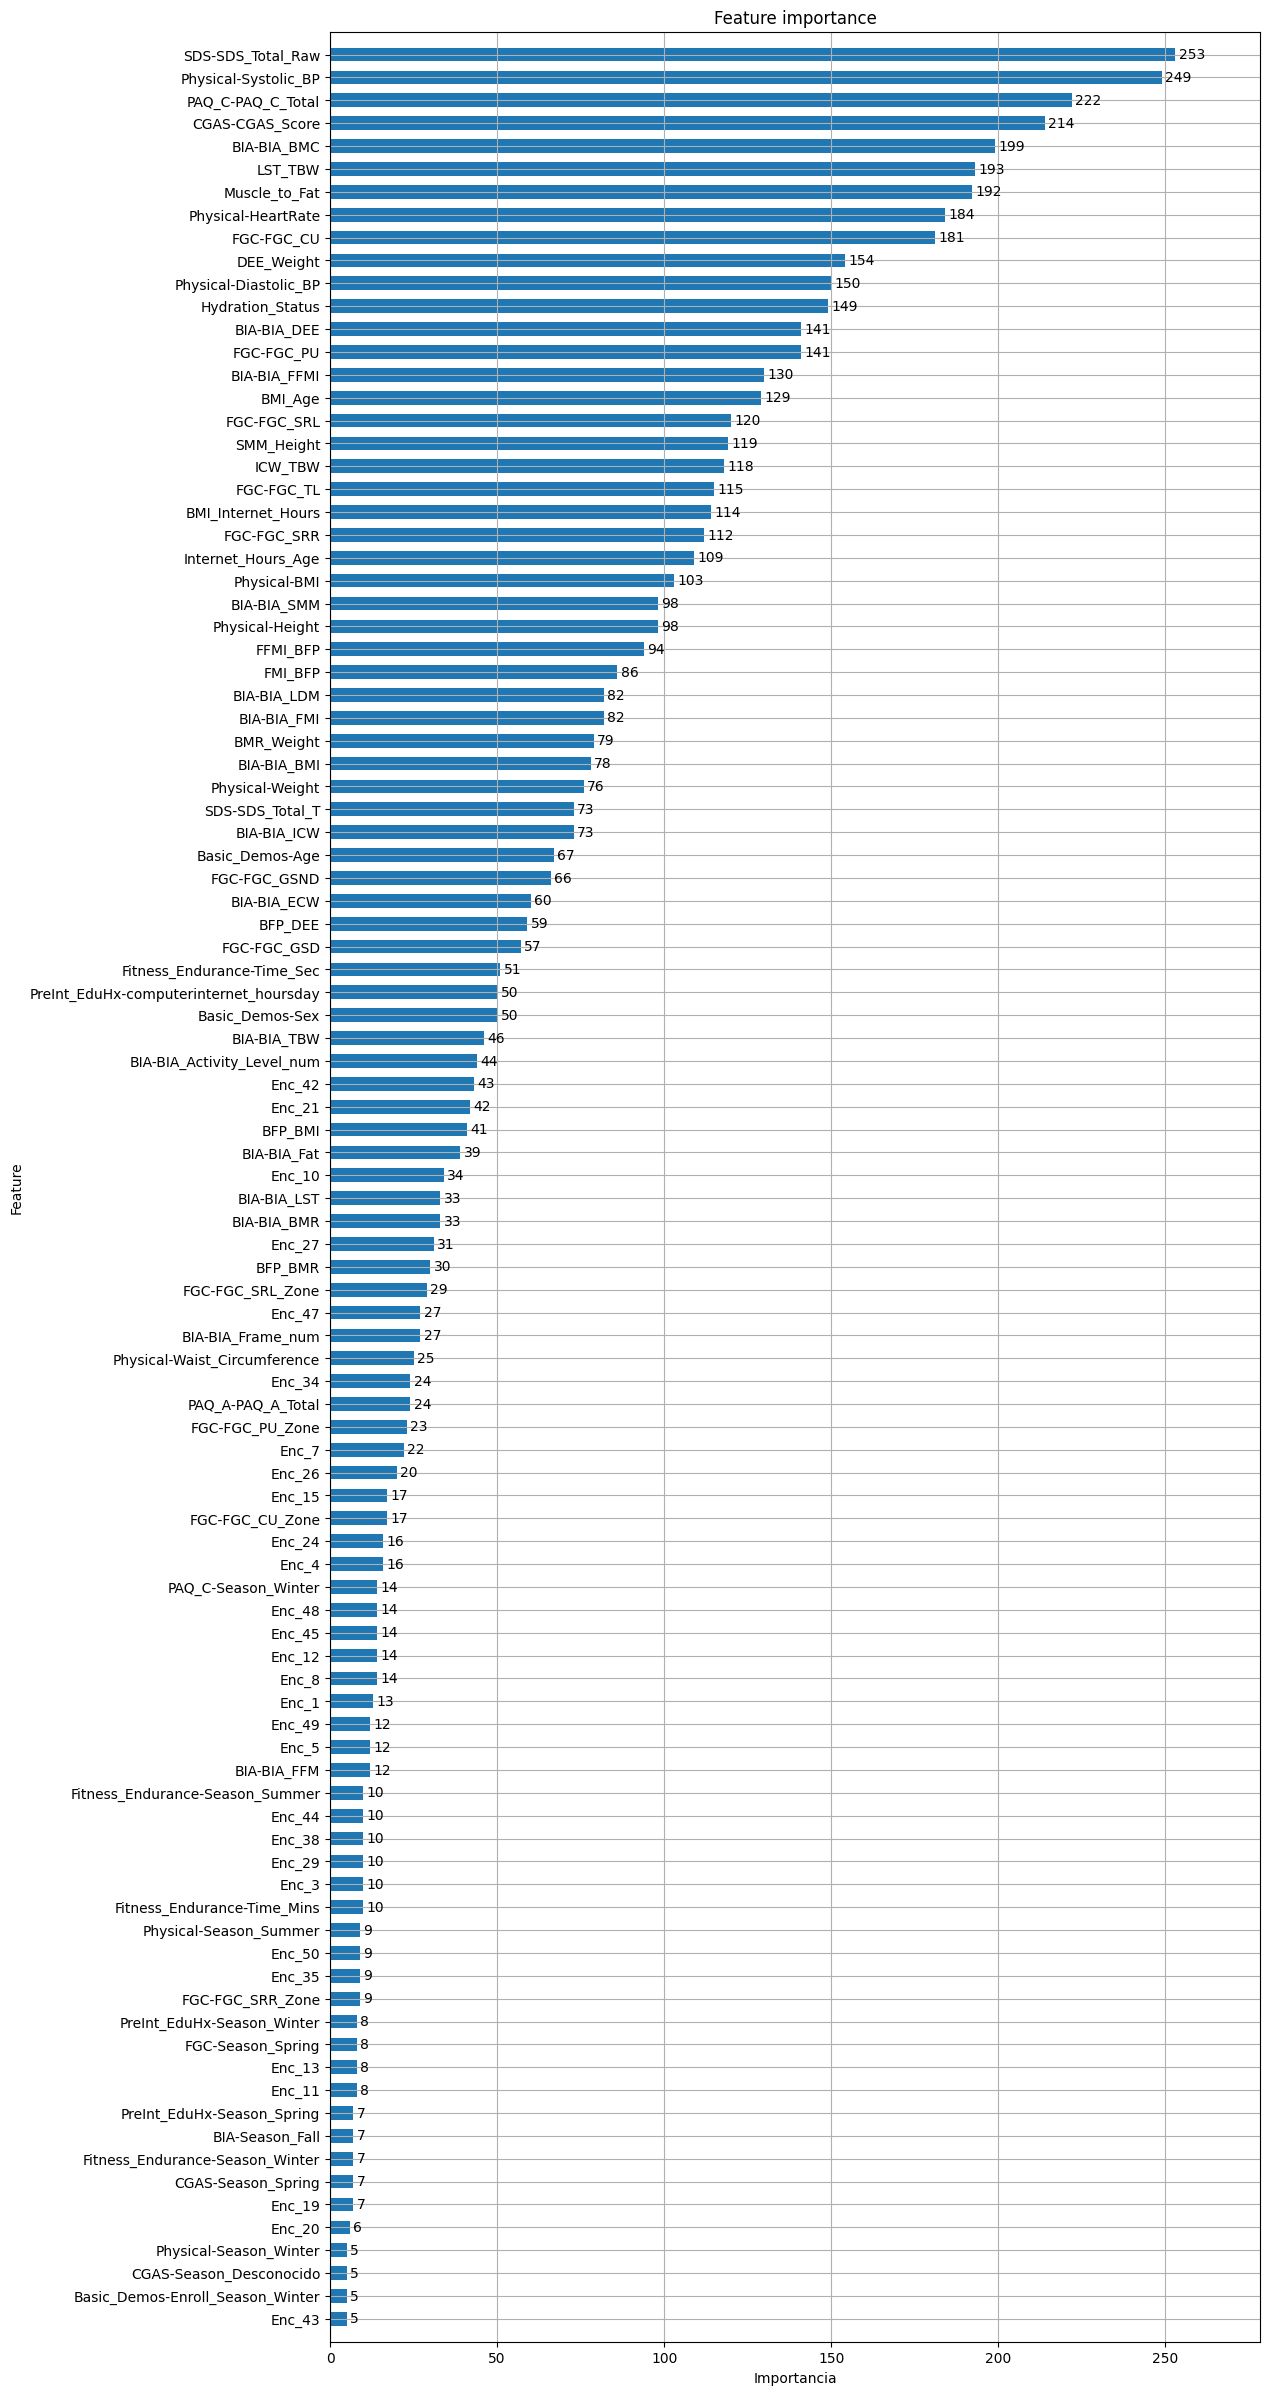

In [25]:
plot_importance(lgbm, figsize=(12, 30), height=0.6, max_num_features=100, title='Feature importance', xlabel='Importancia', ylabel='Feature')

## Remover features

- Ordenamos las features en base a su importancia
- Usamos funcion para iterar desde la feature menos importante, removiendolas si hacerlo mejora la cohen-kappa score

In [26]:
name_list = X.columns.tolist()
weight_list = lgbm.feature_importances_ 
name_weight = []

for i in range(len(name_list)):
    name_weight.append([name_list[i], weight_list[i]])
    
name_weight_sort = sorted(name_weight, key=lambda x: x[1])  

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)
model_t = LGBMRegressor(**lgbm_params, verbose=-1)

model_t.fit(X_train, y_train)
predict_t = model_t.predict(X_test)

score_t = cohen_kappa_score(y_test, round_t(predict_t, t), weights='quadratic')
print('Score con todas las (', len(name_list), ') features: ', score_t, '\n')

X_t = X.copy()
test_t = test.copy()

for i in range(len(name_weight_sort)):
    
    name_i = name_weight_sort[i][0]
    weight_i = name_weight_sort[i][1]
    
    X_i = X_t.drop(columns=name_i, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, test_size=0.2, random_state=23, stratify=y)
    
    model_t.fit(X_train, y_train)
    predict_i = model_t.predict(X_test)
    
    score_i = cohen_kappa_score(y_test, round_t(predict_i, t), weights='quadratic')
    
    if (score_t < score_i):
        X_t.drop(columns=name_i, inplace=True)
        test_t.drop(columns=name_i, inplace=True)
        score_t = score_i
        
        print('Nueva score: ',round(score_i, 5), '| Weight: ', weight_i, '| Feature eliminada: ', name_i)
    
print('\nX_t Shape: ', X_t.shape, 'test_t Shape: ', test_t.shape)

Score con todas las ( 162 ) features:  0.3797796882603631 

Nueva score:  0.38853 | Weight:  0 | Feature eliminada:  Basic_Demos-Enroll_Season_Fall
Nueva score:  0.39752 | Weight:  0 | Feature eliminada:  SDS-Season_Desconocido
Nueva score:  0.39795 | Weight:  1 | Feature eliminada:  CGAS-Season_Fall
Nueva score:  0.39816 | Weight:  1 | Feature eliminada:  BIA-Season_Summer
Nueva score:  0.40858 | Weight:  5 | Feature eliminada:  Enc_40
Nueva score:  0.4121 | Weight:  20 | Feature eliminada:  Enc_26

X_t Shape:  (2736, 156) test_t Shape:  (20, 156)


### Eliminamos 5 features

## XGBoost

In [28]:
xgb_params =  {
    'learning_rate': 0.03,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5, 
    'random_state': 23
}

In [29]:
xgb = XGBRegressor(**xgb_params)

## KNeighborsRegressor

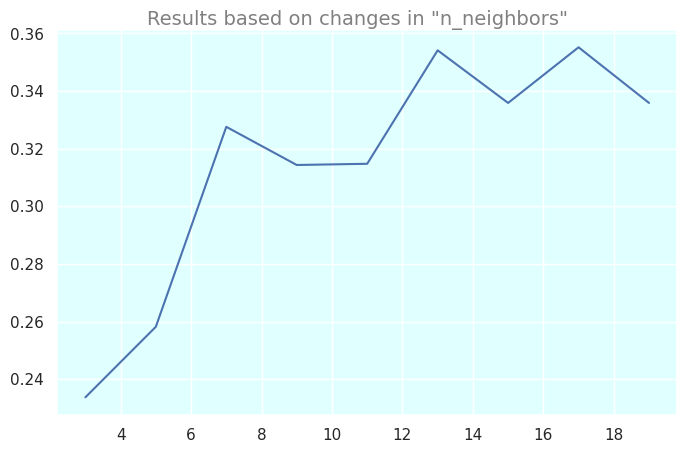

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

def best_knn(coeff): 
    neigh_t = KNeighborsRegressor(n_neighbors=coeff)
    neigh_t.fit(X_train, y_train)
    
    predict_t = neigh_t.predict(X_test)
    score = cohen_kappa_score(y_test, round_t(predict_t, t), weights='quadratic')
    return score

results = {}
for i in range(3, 21, 2):       
    results[i] = best_knn(i)  
    
sns.set()
plt.figure(figsize=(8, 5))
plt.gca().set_facecolor('lightcyan')
plt.suptitle('Results based on changes in "n_neighbors"', y=0.92, fontsize=14, c='gray')

plt.plot(list(results.keys()), list(results.values()))
plt.show() 

In [31]:
knr = KNeighborsRegressor(n_neighbors=13, weights='distance')

## Tabular transformer

Para integrar el tabular transformer en el voting regressor tambien necesitaremos wrappear el modelo en una interfaz compatible con scikit-learn

In [32]:
class TabularTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dropout=0.1):
        super(TabularTransformer, self).__init__()
        
        self.embedding = nn.Linear(input_dim, d_model)
        
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        self.regressor = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.dropout = nn.Dropout(dropout) 

    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.dropout(x) 
        output = self.regressor(x)
        return output.squeeze(1)


class TabularDataset(Dataset):
    def __init__(self, features, targets=None):
        if isinstance(features, pd.DataFrame):
            features = features.to_numpy()
        self.features = torch.tensor(features, dtype=torch.float32)
        if targets is not None:
            if isinstance(targets, (pd.Series, pd.DataFrame)):
                targets = targets.to_numpy()
            self.targets = torch.tensor(targets, dtype=torch.float32).view(-1)
        else:
            self.targets = None
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.targets is None:
            return self.features[idx]
        return self.features[idx], self.targets[idx]
# Wrapper
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model, batch_size=32, lr=1e-4, epochs=50, device=None, weight_decay=0, early_stopping_patience=10, data_augmentation_std=0.01):
        self.model = model
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.weight_decay = weight_decay
        self.early_stopping_patience = early_stopping_patience
        self.data_augmentation_std = data_augmentation_std 

    
    def fit(self, X, y):
        y = np.asarray(y).ravel()
        
        self.model.to(self.device)
        dataset = TabularDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0
            for features, targets in dataloader:
                features, targets = features.to(self.device), targets.to(self.device)
                
                targets = targets.view(-1)
                
                if self.data_augmentation_std > 0:
                    features = features + torch.normal(0, self.data_augmentation_std, size = features.shape).to(self.device)
                
                optimizer.zero_grad()
                predictions = self.model(features)
                
                predictions = predictions.view(-1)
                
                loss = criterion(predictions, targets)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * len(features)
            
            epoch_loss /= len(dataloader.dataset)
            val_loss = self.evaluate(X,y)
            
            print(f'Epoch: {epoch + 1}/{self.epochs}, training loss: {epoch_loss:.4f}, validation loss: {val_loss:.4f}')
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve > self.early_stopping_patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break
                
        return self

    def evaluate(self, X, y):
        self.model.eval()
        dataset = TabularDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        with torch.no_grad():
            total_loss = 0
            for features, targets in dataloader:
                features, targets = features.to(self.device), targets.to(self.device)

                targets = targets.view(-1)
                
                predictions = self.model(features)
                predictions = predictions.view(-1)
                
                loss = nn.MSELoss()(predictions, targets)
                total_loss += loss.item() * len(features)
            
            return total_loss/len(dataloader.dataset)

    
    def predict(self, X):
        self.model.eval()
        dataset = TabularDataset(X)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        predictions = []
        
        with torch.no_grad():
            for features in dataloader:
                features = features.to(self.device)
                preds = self.model(features)
                
                preds = preds.cpu().numpy()
                predictions.append(preds.flatten())
        
        return np.concatenate(predictions)

input_dim = X_t.shape[1]
transformer_model = TabularTransformer(
    input_dim=input_dim, 
    d_model=512, 
    nhead=8, 
    num_layers=4, 
    dropout=0.4
)
pytorch_regressor = PyTorchRegressor(
    transformer_model,
    batch_size=32,
    lr=4e-5,
    epochs=100, 
    device="cuda" if torch.cuda.is_available() else "cpu",
    weight_decay=1e-5,
    early_stopping_patience=10,
    data_augmentation_std = 0.01
)

## TabNet Regressor

In [33]:
"""class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'
        
    def fit(self, X, y):
        X_imputed = self.imputer.fit_transform(X)
            
        if hasattr(y, 'values'):
            y = y.values

        X_train, X_valid, y_train, y_valid = train_test_split(X_imputed, y, test_size=0.2, random_state=23)

        history = self.model.fit(
            X_train = X_train,
            y_train = y_train.reshape(-1, 1),
            eval_set = [(X_valid, y_valid.reshape(-1, 1))],
            eval_name = ['valid'],
            eval_metric = ['mse'],
            max_epochs = 200,
            patience = 20,
            batch_size = 1024,
            virtual_batch_size = 128,
            num_workers = 0,
            drop_last = False,
            callbacks = [
                TabNetPretrainedModelCheckpoint(
                    filepath = self.best_model_path,
                    monitor = 'valid_mse',
                    mode = 'min',
                    save_best_only = True,
                    verbose = True
                )
            ]
        )

        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)

        return self

    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()

    def __deepcopy__(self, memo):
        cls = self.__class__
        result = self.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))

        return result


class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        
        if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)"""

"class TabNetWrapper(BaseEstimator, RegressorMixin):\n    def __init__(self, **kwargs):\n        self.model = TabNetRegressor(**kwargs)\n        self.kwargs = kwargs\n        self.imputer = SimpleImputer(strategy='median')\n        self.best_model_path = 'best_tabnet_model.pt'\n        \n    def fit(self, X, y):\n        X_imputed = self.imputer.fit_transform(X)\n            \n        if hasattr(y, 'values'):\n            y = y.values\n\n        X_train, X_valid, y_train, y_valid = train_test_split(X_imputed, y, test_size=0.2, random_state=23)\n\n        history = self.model.fit(\n            X_train = X_train,\n            y_train = y_train.reshape(-1, 1),\n            eval_set = [(X_valid, y_valid.reshape(-1, 1))],\n            eval_name = ['valid'],\n            eval_metric = ['mse'],\n            max_epochs = 200,\n            patience = 20,\n            batch_size = 1024,\n            virtual_batch_size = 128,\n            num_workers = 0,\n            drop_last = False,\n        

In [34]:
"""tabnet_params = {
    'n_d': 64,        
    'n_a': 64,           
    'n_steps': 5,           
    'gamma': 1.5,          
    'n_independent': 2,    
    'n_shared': 2,         
    'lambda_sparse': 1e-4,  
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

tabnet = TabNetWrapper(**tabnet_params)"""

'tabnet_params = {\n    \'n_d\': 64,        \n    \'n_a\': 64,           \n    \'n_steps\': 5,           \n    \'gamma\': 1.5,          \n    \'n_independent\': 2,    \n    \'n_shared\': 2,         \n    \'lambda_sparse\': 1e-4,  \n    \'optimizer_fn\': torch.optim.Adam,\n    \'optimizer_params\': dict(lr=2e-2, weight_decay=1e-5),\n    \'mask_type\': \'entmax\',\n    \'scheduler_params\': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),\n    \'scheduler_fn\': torch.optim.lr_scheduler.ReduceLROnPlateau,\n    \'verbose\': 1,\n    \'device_name\': \'cuda\' if torch.cuda.is_available() else \'cpu\'\n}\n\ntabnet = TabNetWrapper(**tabnet_params)'

## CatBoost

In [35]:
catboost_params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': 23,
    'verbose': 0,
    'l2_leaf_reg': 10,
    'task_type': 'GPU',
}

catboost = CatBoostRegressor(**catboost_params)

## Voting Regressor

In [36]:
voting = VotingRegressor(estimators = [
                         ('lightgbm', lgbm),
                         ('xgb', xgb),
                         ('catboost', catboost)
])

## Funcion para encontrar thresholds optimos

Buscaremos los thresholds de clasificacion que maximicen el QWK con cross validation y haremos la prediccion final con el ensamble

### Funcion principal para optimizar thresholds y hacer prediccion final

In [37]:
def TrainML(model_class, X, y, test_data, n_splits, SEED):
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = qw_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = qw_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Media Train QWK --> {np.mean(train_S):.4f}")
    print(f"Media Validation QWK ---> {np.mean(test_S):.4f}")
    
    thresholds = optimized_thresholds(fun, y, oof_non_rounded)
    oof_tuned = round_t(oof_non_rounded, thresholds)
    tKappa = qw_kappa(y, oof_tuned)

    print(f"----> || QWK SCORE OPTIMIZADA :: {tKappa:.3f}")
    print(f"----> || THRESHOLDS OPTIMOS :: {thresholds}")
    tpm = test_preds.mean(axis=1)
    tpTuned = round_t(tpm, thresholds)
    
    submission = pd.DataFrame({
        'id': test_data.index,  
        'sii': tpTuned
    })

    return submission, thresholds

# Submission 3

Cambie TabNet Regressor por CatBoostRegressor

In [38]:
submission, thresholds = TrainML(voting, X_t, y, test_t, 5, 23)

# Guardar la predicción
submission.to_csv("submission.csv", index=False)

Training Folds: 100%|██████████| 5/5 [00:22<00:00,  4.43s/it]

Media Train QWK --> 0.7295
Media Validation QWK ---> 0.3851


----> || QWK SCORE OPTIMIZADA :: 0.461
----> || THRESHOLDS OPTIMOS :: [0.58 1.01 2.69]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X_t, y, test_size=0.2, random_state=23, stratify=y
)

scores = []

models = [lgbm, xgb, catboost]
for model in models:
    model.fit(X_train, y_train)

    y_pred_train = round_t(model.predict(X_train), thresholds)
    y_pred_test = round_t(model.predict(X_test), thresholds)

    score_train = qw_kappa(y_train, y_pred_train)
    score_test = qw_kappa(y_test, y_pred_test)

    scores.append((score_train, score_test))

    print(f"Model: {model.__class__.__name__}")
    print(f"  Train QWK: {score_train:.4f}")
    print(f"  Test QWK: {score_test:.4f}")

print("\nResumen de scores:")
for i, (train_score, test_score) in enumerate(scores):
    print(f"Model {models[i].__class__.__name__}: Train QWK = {train_score:.4f}, Test QWK = {test_score:.4f}")

Model: LGBMRegressor
  Train QWK: 0.8220
  Test QWK: 0.4460
Model: XGBRegressor
  Train QWK: 0.8600
  Test QWK: 0.4484
Model: CatBoostRegressor
  Train QWK: 0.6758
  Test QWK: 0.4695

Resumen de scores:
Model LGBMRegressor: Train QWK = 0.8220, Test QWK = 0.4460
Model XGBRegressor: Train QWK = 0.8600, Test QWK = 0.4484
Model CatBoostRegressor: Train QWK = 0.6758, Test QWK = 0.4695


# Conclusion

Despues de experimentar con varias arquitecturas, hyperparametros, y estrategias de preprocesamiento, monitoreando las metricas de cada combinacion (En forma general y de cada modelo en particular), los mejores resultados fueron obtenidos con un Voting Regressor, compuesto por un LightGBM, XGBoostRegressor y CatBoostRegressor con el preprocesamiento e hyperparametros presentes en el notebook.